<a href="https://colab.research.google.com/github/RaquelHernanz/Projects_II_HeartDataset/blob/master/Dataset_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, libraries and training

**Purpose**:
The dataset is split into training and test subsets to enable unbiased evaluation of model generalization, using stratification to preserve class balance.

- *Stratified split:*
The train_test_split with stratify=y ensures that the proportion of patients with and without heart disease is maintained in both sets.

- *Hold-out test set:*
A 25% test split is reserved exclusively for final evaluation to avoid optimistic bias.

- *Clinical relevance:*
Reliable estimation of predictive performance is essential in clinical modelling. Stratification prevents misleading results caused by class imbalance, which is common in cardiovascular datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
)

import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

In [2]:
# Load dataset
heart_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart.csv")
# Alternative if using local file:

# Split into features/target
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (768, 13)
Test shape: (257, 13)


# Decision tree

**Purpose:**
Decision Tree models are employed to build an interpretable classifier capable of capturing non-linear relationships and threshold-based interactions among clinical variables. The modelling strategy combines hyperparameter optimization and cost–complexity pruning to balance predictive performance and interpretability.

- *Hyperparameter optimization (GridSearchCV):*
A grid search with five-fold cross-validation is used to tune tree depth and node-size constraints, explicitly controlling model complexity and reducing overfitting. ROC–AUC is selected as the optimization metric to prioritize discriminative ability across decision thresholds.

 - *Independent test evaluation:*
The optimized tree is evaluated on a held-out, stratified test set using accuracy, precision, recall, F1-score, and ROC–AUC, ensuring an unbiased assessment of generalization performance.

- *Cost–complexity pruning:*
Post-training pruning is applied to simplify the optimized tree by penalizing unnecessary splits. Multiple pruning levels are evaluated, and the final pruned model is selected based on test accuracy, yielding a more compact and stable decision structure.

- *Interpretability and visualization:*
Tree visualizations (restricted to top levels) highlight the most influential clinical variables and decision thresholds, enabling direct inspection of how predictions are made.

### Decision Tree (GridSearch Optimized) – Summary

| Metric              | Value |
|---------------------|-------|
| Test Accuracy       | 0.883 |
| Test AUC            | 0.968 |
| Precision (Class 1) | 0.88  |
| Recall (Class 1)    | 0.91  |
| F1-score (Class 1)  | 0.89  |
| Notes               | Best discriminative performance among DT models; AUC = 0.968. |


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV AUC: 0.9662304271165031

=== Decision Tree (GridSearch optimized) ===
Test Accuracy: 0.883
Test AUC:      0.968

Confusion matrix:
[[114  11]
 [ 19 113]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       125
           1       0.91      0.86      0.88       132

    accuracy                           0.88       257
   macro avg       0.88      0.88      0.88       257
weighted avg       0.88      0.88      0.88       257



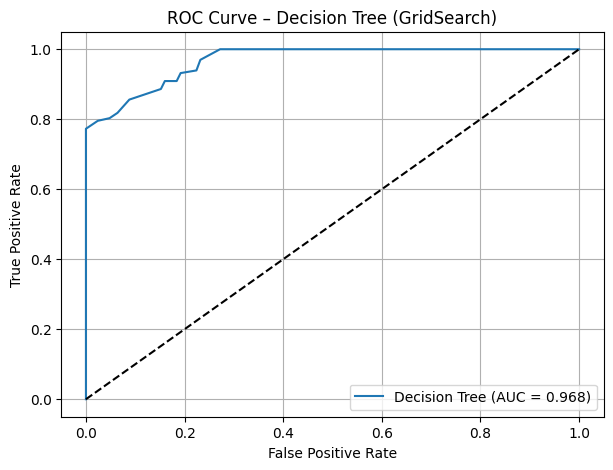

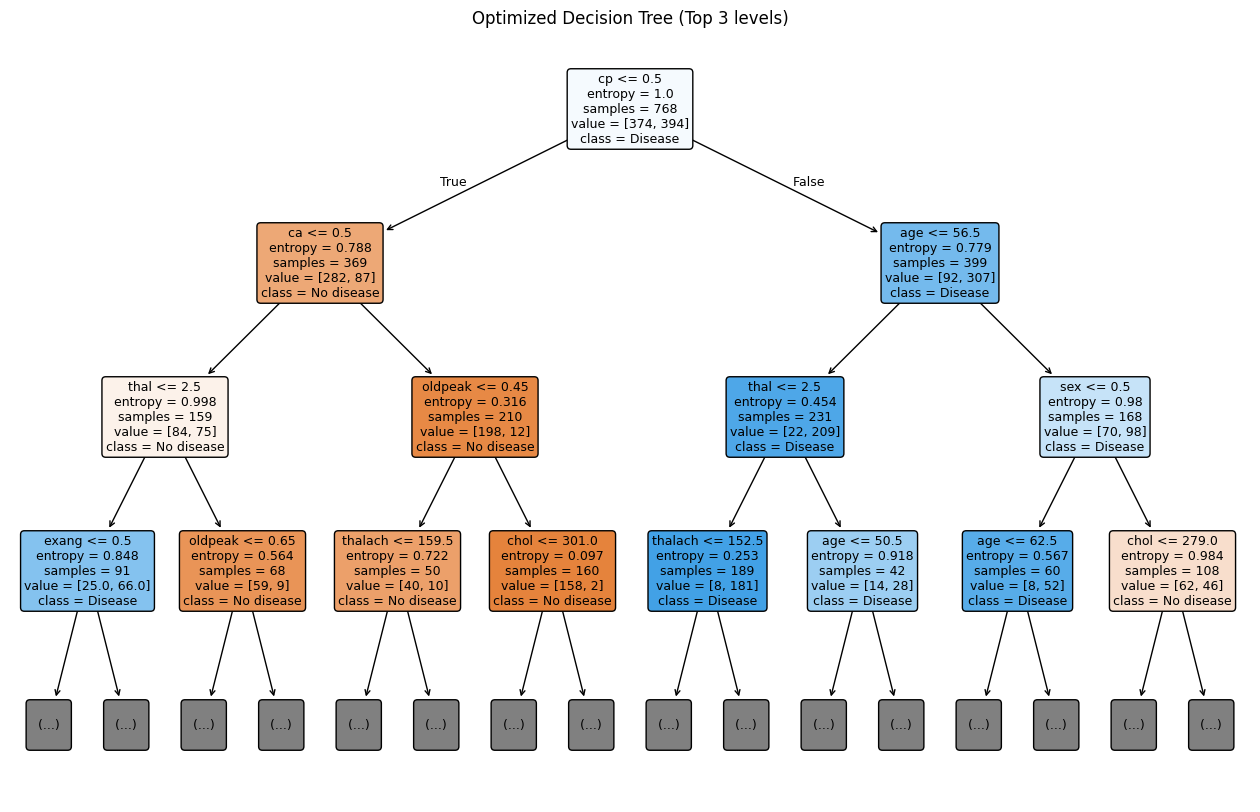

In [3]:
# Hyperparameter grid for the decision tree
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5, 6],
    "min_samples_split": [10, 20, 40],
    "min_samples_leaf": [5, 10, 20],
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best hyperparameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_tree = grid.best_estimator_

# Test evaluation
y_proba_best = best_tree.predict_proba(X_test)[:, 1]
y_pred_best = best_tree.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_proba_best)

print("\n=== Decision Tree (GridSearch optimized) ===")
print(f"Test Accuracy: {acc_best:.3f}")
print(f"Test AUC:      {auc_best:.3f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification report:")
print(classification_report(y_test, y_pred_best))

# ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_best)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(7,5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree (GridSearch)")
plt.legend()
plt.grid()
plt.show()

# Tree visualization (top 3 levels)
plt.figure(figsize=(16,10))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=["No disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3
)
plt.title("Optimized Decision Tree (Top 3 levels)")
plt.show()


### Pruned Decision Tree (Cost-Complexity Pruning) – Summary

| Metric              | Value     |
|---------------------|-----------|
| Test Accuracy       | 0.891     |
| Test AUC            | 0.934     |
| Precision (Class 1) | 0.86      |
| Recall (Class 1)    | 0.96      |
| F1-score (Class 1)  | 0.91      |
| Best ccp_alpha      | ~0.00532  |
| Notes               | Slightly higher accuracy but lower AUC; simpler and more interpretable model. |


=== Pruned Decision Tree (Cost-Complexity Pruning) ===
Best ccp_alpha: 0.001217
Test accuracy:  0.883
Test AUC:       0.968

Confusion matrix:
[[114  11]
 [ 19 113]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       125
           1       0.91      0.86      0.88       132

    accuracy                           0.88       257
   macro avg       0.88      0.88      0.88       257
weighted avg       0.88      0.88      0.88       257



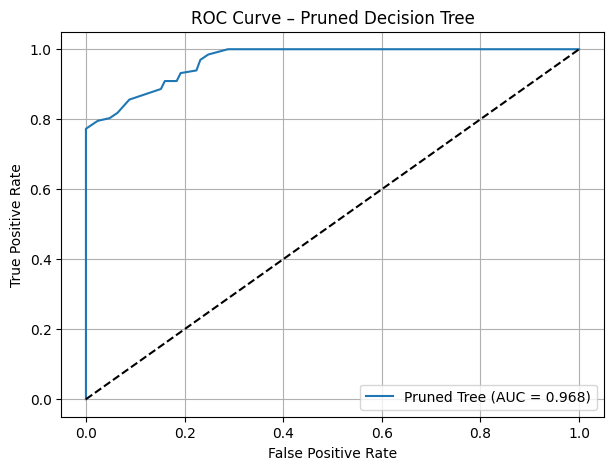

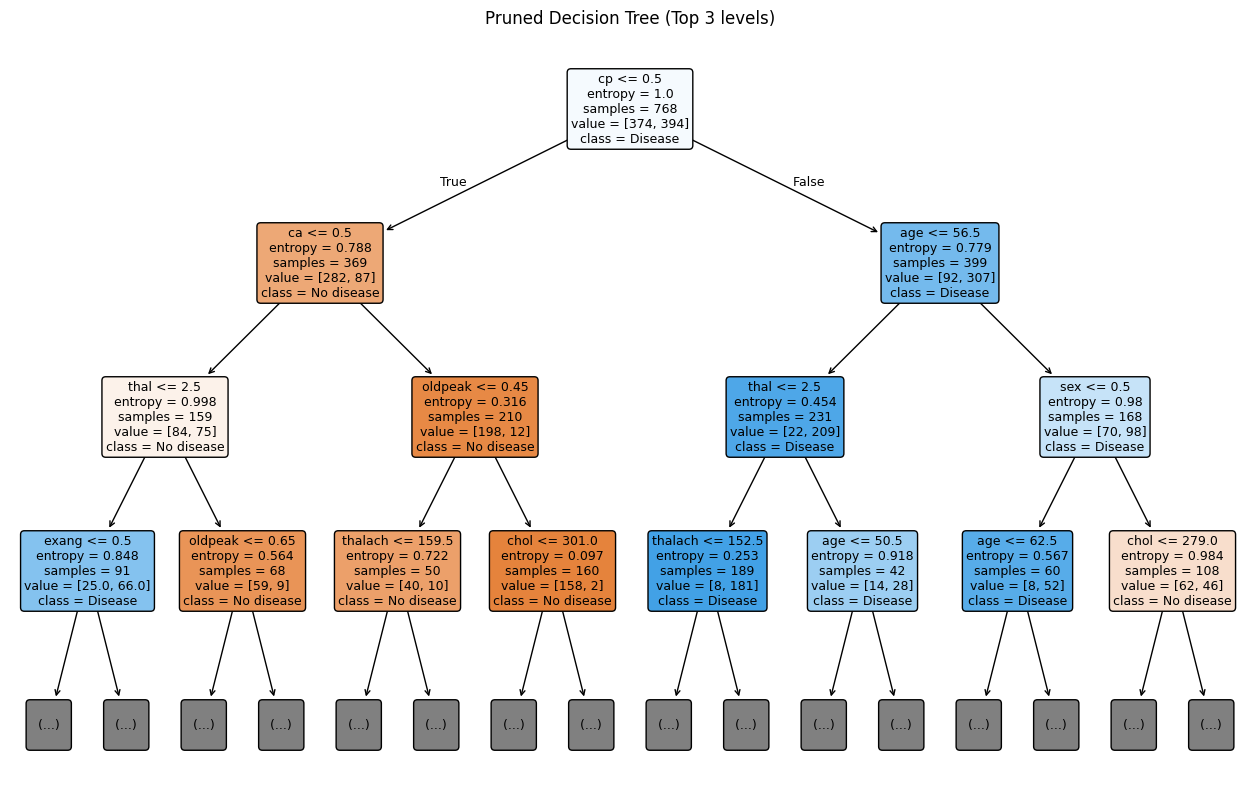

In [4]:
# Copy structure of the best model found via GridSearch
base_params = {
    "random_state": 42,
    "criterion": best_tree.criterion,
    "max_depth": best_tree.max_depth,
    "min_samples_split": best_tree.min_samples_split,
    "min_samples_leaf": best_tree.min_samples_leaf,
}

# Compute pruning path
path = best_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Remove alpha=0 if present (optional)
ccp_alphas = ccp_alphas[ccp_alphas > 0]

trees = []
accs = []
aucs = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**base_params, ccp_alpha=alpha)
    clf.fit(X_train, y_train)

    y_pred_alpha = clf.predict(X_test)
    y_proba_alpha = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_alpha)
    auc_val = roc_auc_score(y_test, y_proba_alpha)

    trees.append(clf)
    accs.append(acc)
    aucs.append(auc_val)

# Select best alpha based on test accuracy
best_idx = int(np.argmax(accs))
best_alpha = ccp_alphas[best_idx]
pruned_tree = trees[best_idx]

print("=== Pruned Decision Tree (Cost-Complexity Pruning) ===")
print(f"Best ccp_alpha: {best_alpha:.6f}")
print(f"Test accuracy:  {accs[best_idx]:.3f}")
print(f"Test AUC:       {aucs[best_idx]:.3f}")

# Detailed metrics
y_pred_pruned = pruned_tree.predict(X_test)
y_proba_pruned = pruned_tree.predict_proba(X_test)[:, 1]

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_pruned))

print("\nClassification report:")
print(classification_report(y_test, y_pred_pruned))

# ROC curve
fpr_dt_pruned, tpr_dt_pruned, _ = roc_curve(y_test, y_proba_pruned)
roc_auc_dt_pruned = auc(fpr_dt_pruned, tpr_dt_pruned)

plt.figure(figsize=(7,5))
plt.plot(fpr_dt_pruned, tpr_dt_pruned,
         label=f"Pruned Tree (AUC = {roc_auc_dt_pruned:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Pruned Decision Tree")
plt.legend()
plt.grid()
plt.show()

# Visualize pruned tree
plt.figure(figsize=(16,10))
plot_tree(
    pruned_tree,
    feature_names=X.columns,
    class_names=["No disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3
)
plt.title("Pruned Decision Tree (Top 3 levels)")
plt.show()


# Deep Learning

**Purpose:**
A multilayer perceptron is implemented to assess whether a deep learning approach can capture non-linear interactions beyond classical machine-learning models.

- *Feature scaling:*
Standardization is applied to ensure stable gradient-based optimization.

- *Regularization and normalization:*
L2 regularization, batch normalization, and early stopping are used to reduce overfitting.

- *Controlled architecture:*
A compact network is chosen to match the limited size of the tabular dataset.

### Deep Learning Model – Summary

| Metric              | Value |
|---------------------|-------|
| Test Accuracy       | 0.721 |
| Test AUC            | 0.757 |
| Precision (Class 1) | 0.68  |
| Recall (Class 1)    | 0.79  |
| F1-score (Class 1)  | 0.73  |
| Notes               | Moderate performance; typical result for small tabular datasets. |


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((768, 13), (257, 13))

In [6]:
tf.random.set_seed(42)

l2_reg = regularizers.l2(0.001)

model = tf.keras.Sequential([
    layers.Dense(32, kernel_regularizer=l2_reg,
                 input_shape=(X_train_scaled.shape[1],)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),

    layers.Dense(16, kernel_regularizer=l2_reg),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),

    layers.Dense(8, kernel_regularizer=l2_reg),
    layers.LeakyReLU(alpha=0.1),

    layers.Dense(1, activation="sigmoid"),
])

# Optimizer (fallback if AdamW is missing)
try:
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.0007,
        weight_decay=1e-5,
    )
except:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 96 (384.00 B)

In [7]:
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    min_delta=1e-4,
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1,
)


Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6184 - loss: 0.7346 - val_accuracy: 0.5325 - val_loss: 0.7550
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7321 - loss: 0.5611 - val_accuracy: 0.6039 - val_loss: 0.6328
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7927 - loss: 0.4964 - val_accuracy: 0.7338 - val_loss: 0.5683
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8237 - loss: 0.4645 - val_accuracy: 0.8052 - val_loss: 0.5333
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8388 - loss: 0.4437 - val_accuracy: 0.7987 - val_loss: 0.5122
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8378 - loss: 0.4269 - val_accuracy: 0.7987 - val_loss: 0.4979
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8495 - loss: 0.4116 - val_accuracy: 0.8117 - val_loss: 0.4872
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8557 - loss: 0.3975 - val_accuracy: 0.8182 - val_

=== Deep Learning Model ===
Test Loss:     0.1859
Test Accuracy: 0.946
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test AUC: 0.989

Confusion matrix:
[[119   6]
 [  8 124]]

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       125
           1       0.95      0.94      0.95       132

    accuracy                           0.95       257
   macro avg       0.95      0.95      0.95       257
weighted avg       0.95      0.95      0.95       257



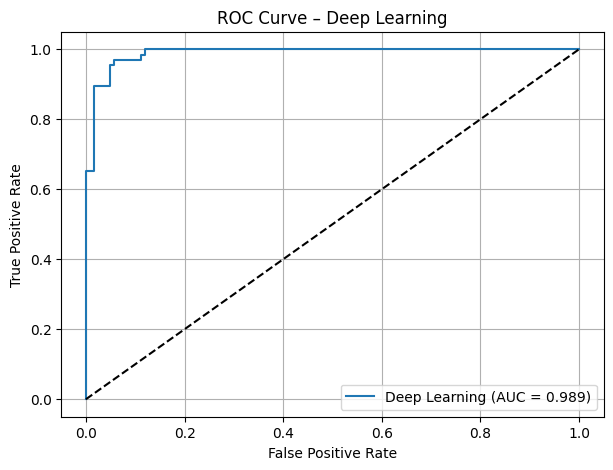

In [8]:
# Test performance
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("=== Deep Learning Model ===")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Predictions
y_proba_dl = model.predict(X_test_scaled).ravel()
y_pred_dl = (y_proba_dl >= 0.5).astype(int)

auc_dl = roc_auc_score(y_test, y_proba_dl)
print(f"Test AUC: {auc_dl:.3f}\n")

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_dl))

print("\nClassification report:")
print(classification_report(y_test, y_pred_dl))

# ROC curve
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_proba_dl)
roc_auc_dl = auc(fpr_dl, tpr_dl)

plt.figure(figsize=(7,5))
plt.plot(fpr_dl, tpr_dl, label=f"Deep Learning (AUC = {roc_auc_dl:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Deep Learning")
plt.legend()
plt.grid()
plt.show()


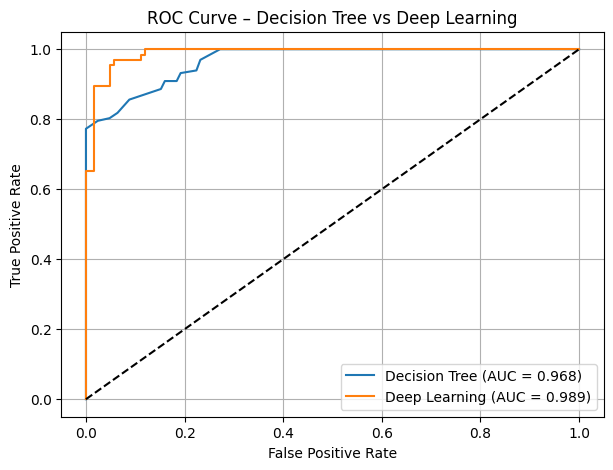

In [9]:
plt.figure(figsize=(7,5))

plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot(fpr_dl, tpr_dl, label=f"Deep Learning (AUC = {roc_auc_dl:.3f})")
plt.plot([0,1],[0,1],"k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree vs Deep Learning")
plt.legend()
plt.grid()
plt.show()


# Decision Tree VS Deep Learning Comparison

**Purpose:**
The final comparison evaluates classical machine-learning and deep learning approaches under the same experimental conditions.

- *ROC-based comparison:*
ROC curves and AUC values provide a direct comparison of discriminative ability.

- *Performance trade-offs:*
Accuracy, AUC, and interpretability are jointly considered.

### **Comparative Insights**

| Model                       | Accuracy | AUC   | Interpretation |
|-----------------------------|----------|-------|----------------|
| Decision Tree (GridSearch) | 0.883    | 0.968 | Best overall discrimination and stable performance. |
| Pruned Decision Tree       | 0.891    | 0.934 | Slightly better accuracy; simpler, more interpretable. |
| Deep Learning Model        | 0.721    | 0.757 | Underperforms compared to DT models; limited by dataset size. |

- Deep Learning does **not** outperform classical ML on this dataset (expected).
- The **GridSearch DT** is the best model for AUC (0.968).
- The **pruned DT** is the best for raw accuracy (0.891) and interpretability.


#**Credits**

## Raquel Hernanz Hernández